<a href="https://colab.research.google.com/github/SaraTouzani/Log_Analysis/blob/master/log_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install httpagentparser
!pip install wget


In [ ]:
import requests
import wget
import re
import pandas as pd
from datetime import datetime
import pytz
import httpagentparser
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%%capture
!wget http://www.almhuette-raith.at/apache-log/access.log

une ligne du log file est comme suit  :



```
# 95.29.198.15 - - [12/Dec/2015:18:32:11 +0100] "POST /administrator/index.php HTTP/1.1" 200 4494 "http://almhuette-raith.at/administrator/" "Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0" "-"\n
```


```
LogFormat "%h %l %u %t \"%r\" %>s %b \"%{Referer}i\" \"%{User-agent}i\"" combined
```

qui correspond à :
`%h` : l'adresse IP du client ;

`%l` : est l'identité RFC ;

`%u` : est l'ID utilisateur;

`%test` : l'heure, par défaut, formatée comme 
```[day/month/year:hour:minute:second zone];```

`\"%r\"` : est la chaîne de requête, au format "method resource protocol"

`%>s` : est le code d'état;

`%O` : est la taille de la demande;

`\"%{Referer}i\"` : est l'en-tête de la requête HTTP 

`\"%{User-Agent}i\" `:est l'en-tête de la requête HTTP User-Agent.

In [ ]:

def parse_str(x):
    """
    Returns the string delimited by two characters.

    Example:
        `>>> parse_str('[my string]')`
        `'my string'`
    """
    if x:
      return x[1:-1]
    else:
      print(x,"null")
      return ''

def parse_browser(x):
    """
    Returns the browser inside the string.

    """
    if x:
      print("start",x)
      u_a=re.findall('" "(.*?)"', x)[0]
      print(u_a)
      browser=(httpagentparser.detect(u_a,fill_none=True))['browser']['name']
      if browser:
        return browser
      else:
        print(browser," browser null")
        return ''
    else:
      print(x," browser null")
      return x

def parse_datetime(x):
    '''
    Parses datetime as:
        `[day/month/year:hour:minute]`
    if parser couldn't handle extracting the date i keep the string as it is and filter them later
    '''
    if x:
      try:
        dt = datetime.strptime(x[1:-7], '%d/%b/%Y:%H:%M:%S')
      except ValueError: 
          dt=None
    else:
      dt=None
    
    return dt

#Chargement / Traitement des Données 




In [ ]:

data = pd.read_csv(
    '/content/access.log',
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
    engine='python',
    na_values='-',
    header=None,
    usecols=[0, 3, 4,  7, 8],
    names=['ip', 'time', 'request',  'referer', 'user_agent'],
    converters={'time': parse_datetime,
                'request': parse_str,
                'referer': parse_str,
                'user_agent': parse_str,
                })

In [ ]:
data.head()

,ip,time,request,referer,user_agent
0,109.169.248.247,2015-12-12 18:25:11,GET /administrator/ HTTP/1.1,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
1,109.169.248.247,2015-12-12 18:25:11,POST /administrator/index.php HTTP/1.1,http://almhuette-raith.at/administrator/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
2,46.72.177.4,2015-12-12 18:31:08,GET /administrator/ HTTP/1.1,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
3,46.72.177.4,2015-12-12 18:31:08,POST /administrator/index.php HTTP/1.1,http://almhuette-raith.at/administrator/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
4,83.167.113.100,2015-12-12 18:31:25,GET /administrator/ HTTP/1.1,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...


In [ ]:
data.dtypes

ip                    object
time          datetime64[ns]
request               object
referer               object
user_agent            object
dtype: object

In [ ]:
data_copy=data.copy()

Extraction de la liste des navigateurs





In [ ]:
browsers = list(map(lambda line: (httpagentparser.detect(line,fill_none=True))['browser']['name'],list(data_copy['user_agent'])))

In [ ]:
data_finale=pd.concat([data,pd.DataFrame(browsers,columns=['browsers'])],axis=1)

In [ ]:
data_finale.head()

,ip,time,request,referer,user_agent,browsers
0,109.169.248.247,2015-12-12 18:25:00,GET /administrator/ HTTP/1.1,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,Firefox
1,109.169.248.247,2015-12-12 18:25:00,POST /administrator/index.php HTTP/1.1,http://almhuette-raith.at/administrator/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,Firefox
2,46.72.177.4,2015-12-12 18:31:00,GET /administrator/ HTTP/1.1,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,Firefox
3,46.72.177.4,2015-12-12 18:31:00,POST /administrator/index.php HTTP/1.1,http://almhuette-raith.at/administrator/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,Firefox
4,83.167.113.100,2015-12-12 18:31:00,GET /administrator/ HTTP/1.1,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,Firefox


# Analyse du Log

## Nombre de lignes dans le fichier :





In [ ]:
print("nombre de lignes: ",len(data_finale))

nombre de lignes:  5880521


## Nombre des @IP uniques qui sont logués :

In [ ]:
print("nombre de ips uniques: ",len(set(data_finale.ip)))

nombre de ips uniques:  75950




## Nombre de  de requêtes en moyenne par IP :

In [ ]:
counts_ips = (data_finale['ip']).value_counts(sort=True)
print("moyenne de requette par /ip: ",counts_ips.mean())

moyenne de requette par /ip:  77.4262146148782


##4) data viz

### la répartition par navigateur des visiteurs

In [ ]:
counts_browser = (data_finale['browsers']).value_counts(sort=True)

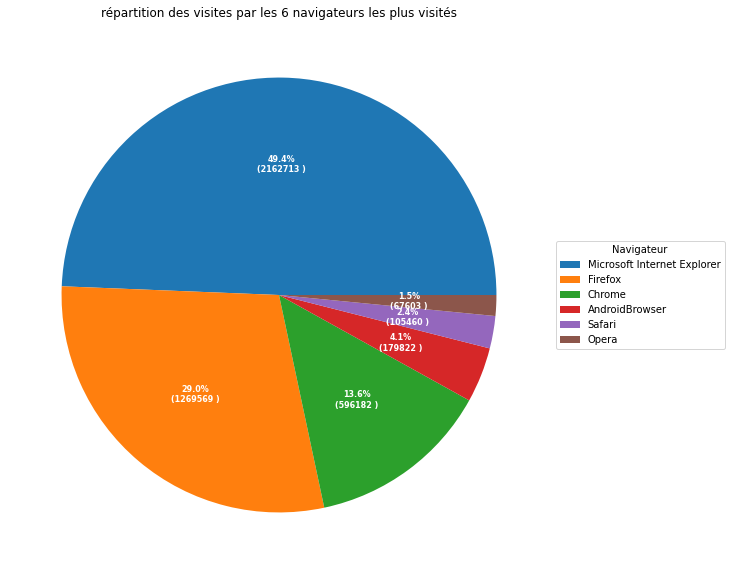

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
data=(counts_browser[0:6]).values
labels=(counts_browser[0:6]).index


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} )".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))


ax.legend(wedges, labels,
          title="Navigateur",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("répartition des visites par les 6 navigateurs les plus visités")

plt.show()

## Ventilation du nombre de visiteurs unique sur le temps par jour de la semaine et par heure.

In [ ]:
dates_index=[i for i in range(len(data_finale)) if type(data_finale.time[i])==pd._libs.tslibs.timestamps.Timestamp]

In [ ]:
data_finale_d=data_finale.loc[dates_index,]##filtrage des ligne qui ne contiennent pas des dates

In [ ]:
## extraction du jour de la semaine
data_finale_d['weekday'] = data_finale_d['time'].apply(lambda x: x.isoweekday())
weekdays = data_finale_d.groupby('weekday')['ip'].agg(len)
weekdays_perc = weekdays.divide(weekdays.sum())*100

In [ ]:
weekdays_perc.sum()

99.99999999999999

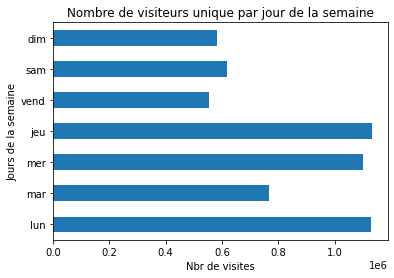

In [ ]:
weekdays.index = ['lun', 'mar', 'mer', 'jeu', 'vend', 'sam', 'dim']
weekdays.plot(kind='barh')
plt.title('Nombre de visiteurs unique par jour de la semaine')
plt.xlabel('Nbr de visites')
plt.ylabel('Jours de la semaine')
plt.show()

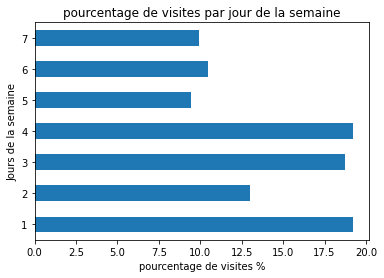

In [ ]:
weekdays.index = ['lun', 'mar', 'mer', 'jeu', 'vend', 'sam', 'dim']
weekdays_perc.plot(kind='barh')
plt.title('pourcentage de visites par jour de la semaine')
plt.xlabel('pourcentage de visites %')
plt.ylabel('Jours de la semaine')
plt.show()

In [ ]:
#data_finale_d.groupby('ip').groups

In [ ]:
## extraction de l'heure
data_finale_d['hour'] = data_finale_d['time'].apply(lambda x: x.hour)
hours = data_finale_d.groupby('hour')['ip'].agg(len)
hours_perc = hours.divide(hours.sum())*100

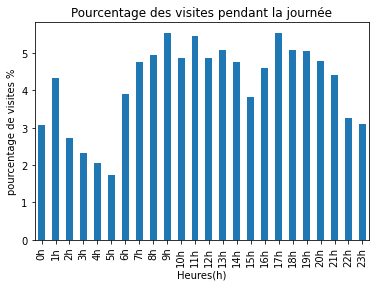

In [ ]:
hours_perc.index = ['0h', '1h', '2h', '3h', '4h', '5h', '6h','7h','8h','9h','10h','11h', '12h', '13h', '14h', '15h', '16h','17h','18h','19h','20h','21h','22h','23h']
hours_perc.plot(kind='bar')
plt.title('Pourcentage des visites pendant la journée')
plt.ylabel('pourcentage de visites %')
plt.xlabel('Heures(h)')
plt.show()

## Annalyse par session

Combien y a t-il de session en moyenne par jour ? Combien y a t-il de
session en moyenne par IP ? Combien y a-t-il de requêtes par session ?

 *Une session est un ensemble de requêtes provenant d'une même IP qui
sont espacées au plus de 30 minutes.*

In [ ]:
List_ip=list()
nbr_session_ip=dict()#nombre de session par ip
nbr_request_session=dict()# nombre de request par session(ip,id_periode_30)
i=0
for ip in set(data_finale_d.ip):
  df=data_finale_d.loc[data_finale_d.ip==ip ,:]
  #df.loc[:,'time'] = pd.to_datetime(df['time'])
  diffs = df['time'] - df['time'].shift()#annoter les requettes chaque 30min pour chaque ip 
  laps = diffs > pd.Timedelta('30 min')
  periods = laps.cumsum().apply(lambda x: x+1)
  nbr_session_ip[ip]=periods.max()
  counts_request_ip = (periods).value_counts(sort=True)
  for session in counts_request_ip.index:
    #print(session,counts_request_ip[session],ip)
    nbr_request_session[(ip,session)]=counts_request_ip[session]
  df.loc[:,'30min_period'] = periods
  List_ip.append(df)
  i=i+1




In [ ]:
len(set(data_finale_d.ip)),len(List_ip)

(75485, 75485)

### Nombre de session en moyenne par IP :

In [ ]:
print(' Nombre moyen de session par ip: ',(sum(nbr_session_ip.values()))/len(nbr_session_ip))

 Nombre moyen de session par ip:  2.8768894482347487


In [ ]:
list(nbr_session_ip.items())[0:5]#(ip:nombre de session)

[('37.71.253.53', 1),
 ('186.11.78.230', 2),
 ('73.202.55.58', 1),
 ('80.211.249.13', 3),
 ('207.58.168.90', 5)]



### Nombre de requêtes par session 
pour avoir le nombre de requêtes pour une session données il faut 
passer comme clé (ip,num_session) exemple(('37.71.253.53', 1))

In [ ]:
print(" Nombre de requette pour la session ('37.71.253.53', 1) est: ",nbr_request_session[('37.71.253.53', 1)])

 Nombre de requette pour la session ('37.71.253.53', 1) est:  3


In [ ]:
print(' Nombre de requette par session: ',list(nbr_request_session.items())[0:5])

 Nombre de requette par session:  [(('37.71.253.53', 1), 3), (('186.11.78.230', 2), 1), (('186.11.78.230', 1), 1), (('73.202.55.58', 1), 1), (('80.211.249.13', 3), 3)]


In [ ]:
Data=pd.concat(List_ip)